In [117]:
from data_processing import *

from scoring_lstm import Model

from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib

from scipy.stats import mode
import pandas as pd
import numpy as np
import warnings
import joblib
import torch
import ast

league_model_col_order = ['forward', 'gp', 'draft_pick', 'is_drafted', 'height', 'weight', 'real_season_age',
                        'gpg', 'apg', 'ppg', 'perc_team_g', 'perc_team_a', 'perc_team_tp', 'AJHL', 
                        'Allsvenskan', 'BCHL', 'CCHL', 'Czech', 'Czech2', 'Jr. A SM-liiga', 'KHL', 'Liiga',
                        'MHL', 'NCAA', 'NHL', 'NLA', 'OHL', 'OJHL', 'QMJHL', 'SHL', 'SJHL', 'SuperElit', 
                        'USHL', 'VHL', 'WHL', 18, 19, 20, 21, 22, 23, 'round_1.0', 
                        'round_2.0', 'round_3.0', 'round_4.0', 'round_5.0', 
                        'round_6.0', 'round_7.0', 'round_8.0', 'round_9.0']

scoring_model_col_order =['forward', 'gp', 'gp_y_plus_1', 'draft_pick', 'is_drafted',
                          'height', 'weight', 'real_season_age', 'gpg', 'apg', 'ppg', 'perc_team_g', 
                          'perc_team_a', 'perc_team_tp', 'AJHL', 'Allsvenskan', 'BCHL', 'CCHL', 'Czech',
                          'Czech2', 'Jr. A SM-liiga', 'KHL', 'Liiga', 'MHL', 'NCAA', 'NHL', 'NLA',
                          'OHL', 'OJHL', 'QMJHL', 'SHL', 'SJHL', 'SuperElit', 'USHL', 'VHL', 'WHL', 
                          18, 19, 20, 21, 22, 23, 'round_1.0', 'round_2.0',
                          'round_3.0', 'round_4.0', 'round_5.0', 'round_6.0', 'round_7.0',
                          'round_8.0', 'round_9.0', 'next_yr_AJHL', 'next_yr_Allsvenskan', 
                          'next_yr_BCHL', 'next_yr_CCHL', 'next_yr_Czech', 'next_yr_Czech2', 
                          'next_yr_Jr. A SM-liiga', 'next_yr_KHL', 'next_yr_Liiga', 
                          'next_yr_MHL', 'next_yr_NCAA', 'next_yr_NHL', 'next_yr_NLA',
                          'next_yr_OHL', 'next_yr_OJHL', 'next_yr_QMJHL', 
                          'next_yr_SHL', 'next_yr_SJHL', 'next_yr_SuperElit', 
                          'next_yr_USHL', 'next_yr_VHL', 'next_yr_WHL']

pd.set_option('max_column', 0)
warnings.filterwarnings('ignore')

class GeneratePlayer(object):
    def __init__(self):
        self.dataset = pd.read_csv('../data/player_season_stats.csv')
        
        self.league_model = joblib.load('../models/predict_next_league.pkl')
        self.scoring_model = joblib.load('../models/scoring_model.pkl')
        self.scoring_lstm = Model() 
        self.scoring_lstm.load_state_dict(torch.load('../models/scoring_lstm_checkpoint.pth'))
        self.scoring_lstm.eval()
        
        self.ppg_model = joblib.load('../models/ppg_team_model.pkl')
        self.gpg_model = joblib.load('../models/gpg_team_model.pkl')
        self.apg_model = joblib.load('../models/apg_team_model.pkl')
        
    def initialize_player(self, playerid):
        self.playerid = playerid
        self.player_df = self.dataset[self.dataset.playerid == int(playerid)]
        self.player_name = self.player_df.player.iloc[0]
        self.current_age = self.player_df.season_age.max()
        self.start_age = self.player_df.season_age.max()
        self.start_league = self.player_df[self.player_df.season_age == self.player_df.season_age.max()].league.iloc[0]
        self.a_proportion = (self.player_df.apg / self.player_df.ppg).median()
        self.g_proportion = 1 - self.a_proportion
        self.projections = pd.DataFrame()
        
    def impute_games_played(self):
        
        team_mask = self.dataset.team.apply(lambda x : len(ast.literal_eval(x)) > 1)

        self.gp_dict = self.dataset[(self.dataset.gp < 85)
                               & (self.dataset.season_age >= 17)
                               & ~(team_mask)
                               & (self.dataset.season_age <= 23)].groupby('league').gp.mean().round().to_dict()
        
        self.gp_full = self.dataset[(self.dataset.gp < 85)
                               & (self.dataset.season_age >= 17)
                               & ~(team_mask)
                               & (self.dataset.season_age <= 23)].groupby('league').gp.apply(lambda x: mode(x)[0][0]).round().to_dict()
        
        
    def load_features(self, target):
        
        self.features, self.target, self.scaler = prepare_features(self.dataset, target)
        
    def get_player_index(self):
    
        return (self.player_df.playerid.iloc[0], self.player_df.player.iloc[0])
    
    def get_league_index(self):
        
        self.league_index = { i:k for i, k in enumerate(np.unique(self.dataset['league']))}
    
    def generate_league_season(self, player_df):
        
        # load entire model feature set
        self.load_features('league_y_plus_1')
        # instantiate league index
        self.get_league_index()
        # league to game played mapping
        self.impute_games_played()
        # Pad player career to get entries for all possible seasons
        self.pad_player = pad_data(player_df, [self.get_player_index()])
        # Get age of the last played season
        self.current_age = self.pad_player.season_age.max()
        # create retrieve data from season and produce model features
        self.current_season = self.pad_player[self.pad_player.season_age == self.current_age]
        self.current_league = self.current_season.league.iloc[0]
        self.current_season = prepare_features_single_season(self.current_season, self.scaler, 'league_y_plus_1')
        # append model features to entire dataset to inherent all the necessary columns
        player_league_features = pd.DataFrame(self.features.loc[self.get_player_index()].append(
            self.current_season.droplevel([0,1])).loc[self.current_age])
        # predict next year league probabilities for the last played season
        league_pred = self.league_model.predict_proba(
            player_league_features.T.fillna(0)[league_model_col_order]).round(3)
        # write league probabilities to player dataframe to iterate over
        league_probs = pd.DataFrame([[self.current_league,
                                      self.league_index[idx], 
                                      np.squeeze(league_pred)[idx]] for idx in np.flatnonzero(league_pred > 0)],
                                    columns=['start_league', 'league', 'probability'],
                                    index=pd.MultiIndex.from_tuples(
                                        [self.get_player_index() + (self.current_age + 1,)\
                                         for i in range(len(np.flatnonzero(league_pred > 0)))],
                                        names=['playerid', 'player', 'season_age'])
                                   )# incriment year
        
        # sort by probability
        league_probs.sort_values('probability', ascending=False, inplace=True)
        # only return values that > 2% probability
        league_probs = league_probs[(league_probs.probability >= 0.1) |
                                              (league_probs.league == 'NHL')].reset_index().head(3)
        # redistribute probabilities 
        league_probs.probability /= league_probs.probability.sum()
    
        league_probs['gp'] = league_probs.league.map(self.gp_dict)

        self.league_probs = league_probs
        
    def generate_league_scoring(self, player_df):
        # load entire model feature set
        self.load_features('ppg_y_plus_1')

        for i, (_, sim) in enumerate(self.league_probs.iterrows()):
            # create retrieve data from season and produce model features
            self.current_season = self.pad_player[self.pad_player.season_age == self.current_age]
            self.current_season['gp_y_plus_1'] = sim['gp']
            self.current_season = prepare_features_single_season(self.current_season, 
                                                                       self.scaler, 
                                                                       'ppg_y_plus_1')
            self.current_season['next_yr_{}'.format(sim['league'])] = 1
            # player features for lstm
            player_league_features = pd.DataFrame(
                self.features.loc[self.get_player_index()]\
                                        .append(self.current_season.droplevel([0,1]))
            ).fillna(0)[scoring_model_col_order]

            # pad sequence for LSTM
            player_league_features = pad_sequence(player_league_features).values

            with torch.no_grad():
                lstm_preds = torch.Tensor([])  # to store our predictions for season t+1
                pred_t, _ = self.scoring_lstm(player_league_features,
                                                 np.ndarray((player_league_features.shape[0], 1))) # dummy target array
                lstm_preds = torch.cat((lstm_preds, pred_t))

            self.league_probs.ix[i, 'ppg'] = lstm_preds.detach().numpy()[-1]
        
        # partition ppg into assists and goals
        self.league_probs['gpg'] = self.league_probs.ppg * self.g_proportion
        self.league_probs['apg'] = self.league_probs.ppg * self.a_proportion
        # Append predictions to projections dataframe
#         self.projections = self.projections.append(self.league_probs.reset_index())
            
    def generate_league_scoring_baseline(self):

        # load entire model feature set
        self.load_features('ppg_y_plus_1')
        # instantiate league index
        self.get_league_index()
        # league to game played mapping
        self.impute_games_played()
        
        # Pad player career to get entries for all possible seasons
        pad_player = pad_data(self.player_df, [self.get_player_index()])
        self.current_age = pad_player.season_age.max()

        for i, (_, sim) in enumerate(self.league_probs.iterrows()):
            # create retrieve data from season and produce model features
            self.current_season = pad_player[pad_player.season_age == self.current_age]
            self.current_season['gp_y_plus_1'] = sim['gp_y_plus_1']
            self.current_season = prepare_features_single_season(self.current_season, self.scaler, 'ppg_y_plus_1')
            self.current_season['next_yr_{}'.format(sim['league'])] = 1
            # append model features to entire dataset to inherent all the necessary columns
            player_league_features = pd.DataFrame(self.features.loc[self.get_player_index()].append(
                self.current_season.droplevel([0,1])).loc[self.current_age])

            scoring_pred = self.scoring_model.predict(
                        player_league_features.T.fillna(0)[scoring_model_col_order]).round(3)

            self.league_probs.ix[i, 'ppg'] = scoring_pred
    
    def interpolate_team_scoring(self):

        features = self.league_probs[['ppg', 'apg', 'gpg']].merge(
            pd.get_dummies(self.league_probs.reset_index()['league']),
            left_index=True,
            right_index=True).merge(
            pd.get_dummies(self.league_probs.reset_index()['season_age'].astype(int)),
            left_index=True,
            right_index=True)

        features.index = np.full((features.shape[0],), self.current_age + 1)

        X = self.features.loc[self.get_player_index()]
        for _, row in features.iterrows():
            X = X.append(row.to_frame().T)
            
        X = X.loc[(self.current_age + 1)]

        league_feats = [v for k,v in self.league_index.items()][1:]
        age_feats = [i for i in range(18, 24)]
        
        input_dim = X.shape[0] if X.shape[0] != self.features.shape[1] else 1
        
        self.league_probs['perc_team_a'] = self.apg_model.predict(
            X.fillna(0)[['apg'] + league_feats + age_feats].values.reshape(input_dim, self.apg_model.coef_.shape[0]))
        self.league_probs['perc_team_g'] = self.gpg_model.predict(
            X.fillna(0)[['gpg'] + league_feats + age_feats].values.reshape(input_dim, self.apg_model.coef_.shape[0]))
        self.league_probs['perc_team_tp'] = self.ppg_model.predict(
            X.fillna(0)[['ppg'] + league_feats + age_feats].values.reshape(input_dim, self.ppg_model.coef_.shape[0]))

    def collect_expected_points(self):
    
        return self.league_probs.groupby(['playerid', 'player', 'age', 'league']).prod(axis=1).prod(axis=1)
    
    def recursive_season_concat(self, season, df = pd.DataFrame()):
        
        prev_season = self.projections[self.projections.node == season['start_node']]
        
        if prev_season.empty:
            
            return df.append(season.to_frame().T)

        else:
            df = df.append(season)
#             season = df.loc[df.season_age == df.season_age.min()].squeeze()

            return self.recursive_season_concat(prev_season.squeeze(), df).sort_values('season_age')

    def fill_player_attributes(self, season):
        
        df = self.player_df.append(self.recursive_season_concat(season))
        df['position'] = df['position'].fillna(method = 'ffill') 
        df['height'] = df['height'].fillna(method = 'ffill')
        df['weight'] = df['weight'].fillna(method = 'ffill')
        df['draft_year_eligible'] = df['draft_year_eligible'] .fillna(method = 'ffill') 
        df['draft_year'] = df['draft_year'] .fillna(method = 'ffill') 
        df['draft_round'] = df['draft_round'].fillna(method = 'ffill')
        df['draft_pick'] = df['draft_pick'].fillna(method = 'ffill')
        df['real_season_age'] = (df['real_season_age'].min() + np.arange(1, len(df) + 1))
        df['start_year'] = (df['start_year'].min() + np.arange(1, len(df) + 1))
        df['end_year'] = (df['end_year'].min() + np.arange(1, len(df) + 1))

        return df
            
    def simulate_player_development(self, node_counter=1): 
    
        while self.current_age + 1 <= 23:

            print(f'--- Simulating Seasons --- {self.player_name} --- Age: {int(self.current_age)}')

            if node_counter == 1:
                self.generate_league_season(self.player_df)
                self.generate_league_scoring(self.player_df)
                self.interpolate_team_scoring()
                self.league_probs['start_node'] = node_counter
                self.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(self.league_probs))

                self.current_simulation = self.league_probs
                self.projections = self.projections.append(self.current_simulation)
                node_counter += len(self.league_probs)
                self.current_age += 1
                print(f'--- Simulation Complete --- {self.player_name} --- Age: {int(self.current_age)}')


            print(f'--- Simulating Seasons --- {self.player_name} --- Age: {int(self.current_age)}')
            simulated_seasons = pd.DataFrame()

            for _, sim in self.current_simulation.iterrows():
                player_df = self.fill_player_attributes(sim)
                self.generate_league_season(player_df)
                self.generate_league_scoring(player_df)
                self.interpolate_team_scoring()
                self.league_probs['start_node'] = sim['node']
                self.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(self.league_probs))
                # Append predictions to projections dataframe
                simulated_seasons = simulated_seasons.append(self.league_probs)
                self.projections = self.projections.append(self.league_probs)
                node_counter += len(self.league_probs)

            self.current_simulation = simulated_seasons
            print(f'--- Simulation Complete --- {self.player_name} --- Age: {int(self.current_age)}')
            self.current_age += 1

            self.simulate_player_development(node_counter)
        
        # to calculate epoints let players play full seasons
        self.projections['gp'] = self.projections.league.map(self.gp_full)
        self.projections['epoints'] = self.projections.ppg * self.projections.gp
        
    def generate_network_graph(self):
        
        self.G = nx.convert_matrix.from_pandas_edgelist(self.projections.round(3),
                             source='start_node',
                             target='node',
                             edge_attr=['probability', 'epoints'],
                             create_using=nx.DiGraph())
        
        self.G.nodes[1]['league'] = self.start_league
        self.G.nodes[1]['age'] = self.start_age
        self.G.nodes[1]['epoints'] = self.player_df[self.player_df.season_age == self.player_df.season_age.max()].tp.values.item()
        self.G.nodes[1]['cond_prob'] = node_probability(self.G, 1)
        self.G.nodes[1]['xvalue'] = round(node_expected_value(self.G, 1),3)
        
        for n in self.projections.node.values:
            self.G.nodes[n]['league'] = self.projections[self.projections.node == n].league.values.item()
            self.G.nodes[n]['age'] = self.projections[self.projections.node == n].season_age.values.item()
            self.G.nodes[n]['epoints'] = self.projections[self.projections.node == n].epoints.values.item()
            self.G.nodes[n]['cond_prob'] = node_probability(self.G, n)
            self.G.nodes[n]['xvalue'] = round(node_expected_value(self.G, n),3)
        
        self.calculate_value_metrics()
        
    def plot_network_graph(self):
        
        matplotlib.rc('font',family='monospace')

        fig, ax = plt.subplots(figsize=(20,10))

        # create tree layout and rescale based on age
        pos = graphviz_layout(self.G, prog='dot')
        # array of ages for y-axis
        ages = np.arange(self.start_age,
                         self.projections.season_age.astype(int).max() + 1,
                         1)
        # rescale x,y coordinates
        y = np.array([xy[1] for _, xy in pos.items()])
        y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
        y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
        pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

        # set params
        node_sizes = [int(self.G.nodes[1]['epoints'] *10)] + [int(v * 10) for v in self.projections.epoints.values.tolist()]

        # draw nodes
        nodes = nx.draw_networkx_nodes(self.G,
                                       pos,
                                       node_size=node_sizes,
                                       node_color='dodgerblue',
                                       ax=ax)
        node_labels = nx.get_node_attributes(self.G, 'league')
        nx.draw_networkx_labels(self.G,
                                pos,
                                node_labels,
                                font_size=14,
                                ax=ax, 
                                font_family='monospace', 
                                font_color='black', 
                                font_weight='bold',
                                font_stretch = 'semi-expanded')

        # draw edges
        edges = nx.draw_networkx_edges(self.G,
                                       pos, 
                                       arrowstyle='->', 
                                       arrowsize=20, 
                                       edge_cmap=plt.cm.Greys, 
                                       width=3,
                                       ax=ax)
        edge_labels = nx.get_edge_attributes(self.G, 'probability')
        nx.draw_networkx_edge_labels(self.G, 
                                     pos, 
                                     edge_labels, 
                                     font_size=12,
                                     ax=ax, 
                                     font_family='monospace')

        # set alpha value for each edge
        for i in range(len(self.projections)):
            edges[i].set_alpha(self.projections.probability.values[i])

        # colourscale for colourbar
        pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Greys)
        pc.set_array([(5 + i) / (30 + 4) for i in range(30)])
        plt.colorbar(pc)
        # create legend for projected points
        custom_leg = [mlines.Line2D([0], [0], marker='o', color='dodgerblue', linestyle='None') for _ in range(0,5)]
        # 4 part distirubtion
        Q1 = np.percentile(self.projections.epoints.unique(), 25, interpolation = 'midpoint').round(1) 
        Q2 = np.percentile(self.projections.epoints.unique(), 50, interpolation = 'midpoint').round(1) 
        Q3 = np.percentile(self.projections.epoints.unique(), 75, interpolation = 'midpoint').round(1)
        Q4 = np.percentile(self.projections.epoints.unique(), 100, interpolation = 'midpoint').round(1)
        point_range=[Q4, Q3, Q2, Q1]
        leg = plt.legend(custom_leg, point_range, title = 'Projected Points')
        for i, points in enumerate(point_range):
            leg.legendHandles[i]._legmarker.set_markersize(points / 5)

        # axis changes
        ax.set_yticks(ages)
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
        ax.set_ylabel('Season Age', size=16, weight='bold')
        ax.set_xlabel('MeaningleX Axis', size=12)
        plt.gca().yaxis.grid(True, linestyle='--',)
        plt.title(f"{self.player_name} Player Development", fontsize=18, fontweight='bold')
        footnote = """By: Connor Jung @ConnorJungle, Data Source: Elite Prospects"""
        plt.figtext(0.125, 0.05, footnote)
        # save image
        fname = '_'.join(self.player_name.split()).lower()
        plt.savefig(f"../images/{fname}_{self.playerid}_player_development_network_graph.png",
           dpi=300,
           format='png')
        
        plt.show()
        
    def calculate_value_metrics(self):
            
        self.projections = self.projections.assign(nhl_xvalue=np.nan,xvalue=np.nan,cond_probability=np.nan,)
            
        for n in self.projections.node.values:
            # add expected value to data frame
            self.projections.loc[self.projections.node == n, ['nhl_xvalue']] = nhl_expected_value(self.G, n)
            self.projections.loc[self.projections.node == n, ['xvalue']] = node_expected_value(self.G, n)
            self.projections.loc[self.projections.node == n, ['cond_probability']] = node_probability(self.G, n)
            
    def run(self, playerid):
    
        self.initialize_player(playerid)
        self.simulate_player_development()
        self.generate_network_graph()
        self.plot_network_graph()

        return self.projections
        
def node_probability(G, node):
    
    probabilities = []
    for n in sorted(nx.ancestors(G, node))[::-1]:
        probabilities.append(G.edges[(n, node)]['probability'])
        node=n
    return np.prod(probabilities)

def node_expected_value(G, node):

    return sum(G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] for n in nx.ancestors(G, node) | {node})

def nhl_expected_value(G, node):
    
    value = []
    for n in sorted(nx.descendants(G, node)):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['xvalue'] for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)


In [118]:
player = GeneratePlayer()

[01:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


--- Simulating Seasons --- Ty Dellandrea --- Age: 20
--- Simulation Complete --- Ty Dellandrea --- Age: 21
--- Simulating Seasons --- Ty Dellandrea --- Age: 21
--- Simulation Complete --- Ty Dellandrea --- Age: 21
--- Simulating Seasons --- Ty Dellandrea --- Age: 22
--- Simulating Seasons --- Ty Dellandrea --- Age: 22
--- Simulation Complete --- Ty Dellandrea --- Age: 22


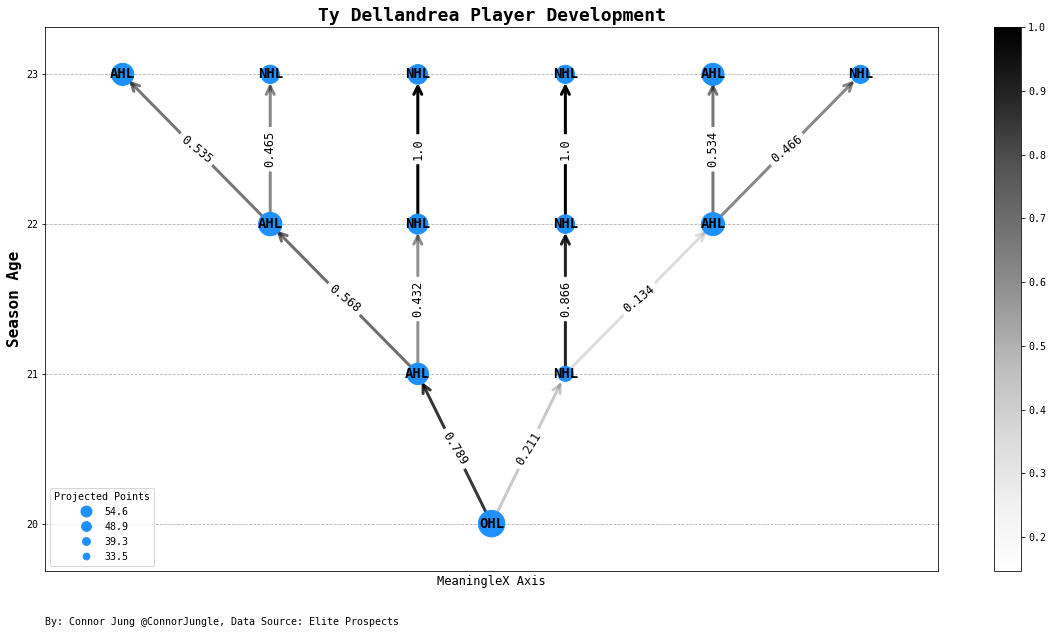

In [119]:
player.initialize_player('399353')
player.simulate_player_development(node_counter=1)
player.generate_network_graph()
player.plot_network_graph()

In [120]:
def run(self, playerid):
    
    self.initialize_player(playerid)
    self.simulate_player_development()
    self.generate_network_graph()
    self.plot_network_graph()
    
    return self.projections

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node,epoints,nhl_xvalue,xvalue,cond_probability
0,399353,Ty Dellandrea,21.0,OHL,AHL,0.788591,76.0,0.600808,0.274801,0.326008,0.063353,0.087372,0.072005,1,2,45.661437,121.4,72.053748,0.789000
1,399353,Ty Dellandrea,21.0,OHL,NHL,0.211409,82.0,0.279383,0.127786,0.151597,0.036167,0.047813,0.040726,1,3,22.909406,45.0,9.667769,0.211000
0,399353,Ty Dellandrea,22.0,AHL,AHL,0.567625,76.0,0.718266,0.328524,0.389742,0.075535,0.104548,0.085873,2,4,54.588226,28.0,73.391468,0.448152
1,399353,Ty Dellandrea,22.0,AHL,NHL,0.432375,82.0,0.491787,0.224936,0.266851,0.057264,0.077749,0.064806,2,5,40.326574,52.2,41.235697,0.340848
0,399353,Ty Dellandrea,22.0,NHL,NHL,0.866460,82.0,0.419256,0.191761,0.227495,0.050454,0.068001,0.057005,3,6,34.378985,24.4,18.845803,0.182726
1,399353,Ty Dellandrea,22.0,NHL,AHL,0.133540,76.0,0.696376,0.318512,0.377864,0.073480,0.101606,0.083518,3,7,52.924592,1.7,4.489170,0.028274
0,399353,Ty Dellandrea,23.0,AHL,AHL,0.534591,76.0,0.644448,0.294761,0.349687,0.068924,0.095083,0.078323,4,8,48.978065,0.0,46.972182,0.239761
1,399353,Ty Dellandrea,23.0,AHL,NHL,0.465409,82.0,0.409491,0.187295,0.222196,0.049857,0.067144,0.056345,4,9,33.578252,0.0,27.989579,0.208391
0,399353,Ty Dellandrea,23.0,NHL,NHL,1.000000,82.0,0.466702,0.213462,0.253239,0.055229,0.074833,0.062498,5,10,38.269541,0.0,52.176386,0.340848
0,399353,Ty Dellandrea,23.0,NHL,NHL,1.000000,82.0,0.406995,0.186153,0.220841,0.049623,0.066809,0.056076,6,11,33.373561,0.0,24.392869,0.182726


# Debugging

In [72]:
player.G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16))

In [42]:
[int(v * 10) for v in player.projections.epoints.values.tolist()]

[515, 862, 417, 574, 410, 446, 394, 581, 454, 390, 456, 402, 341, 450, 516]

In [350]:
player.initialize_player('512832')

node_counter = 1

player.generate_league_season(player.player_df)
player.generate_league_scoring(player.player_df)
player.interpolate_team_scoring()
player.league_probs['start_node'] = node_counter
player.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(player.league_probs))
    
current_simulation = player.league_probs
player.projections = player.projections.append(current_simulation)
node_counter += len(player.league_probs)
player.current_age += 1

In [351]:
current_simulation

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node
0,512832,Vasili Podkolzin,20.0,KHL,KHL,0.885642,37.0,0.424054,0.137818,0.286236,0.059610,0.048842,0.055320,1,2
1,512832,Vasili Podkolzin,20.0,KHL,NHL,0.114358,64.0,0.479120,0.155714,0.323406,0.065047,0.055833,0.061505,1,3


In [358]:
simulated_seasons = pd.DataFrame()

for _, sim in current_simulation.iterrows():
    player_df = player.fill_player_attributes(sim)
    player.generate_league_season(player_df)
    player.generate_league_scoring(player_df)
    player.interpolate_team_scoring()
    player.league_probs['start_node'] = sim['node']
    player.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(player.league_probs))
    # Append predictions to projections dataframe
    simulated_seasons = simulated_seasons.append(player.league_probs)
    player.projections = player.projections.append(player.league_probs)
    node_counter += len(player.league_probs)

current_simulation = simulated_seasons
player.current_age += 1

(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]
(5, 45)
(4, 1)
[[19.52]
 [20.52]
 [21.52]
 [22.52]]


### Prepare NetworkX df

In [34]:
df = player.projections.copy().round(3)
df['start_age'] = df.season_age - 1
df['weight'] = df.probability
df['epoints'] = df['ppg'] * df['gp']

### Using NetworkX to assign Simulated Seasons in Graphs

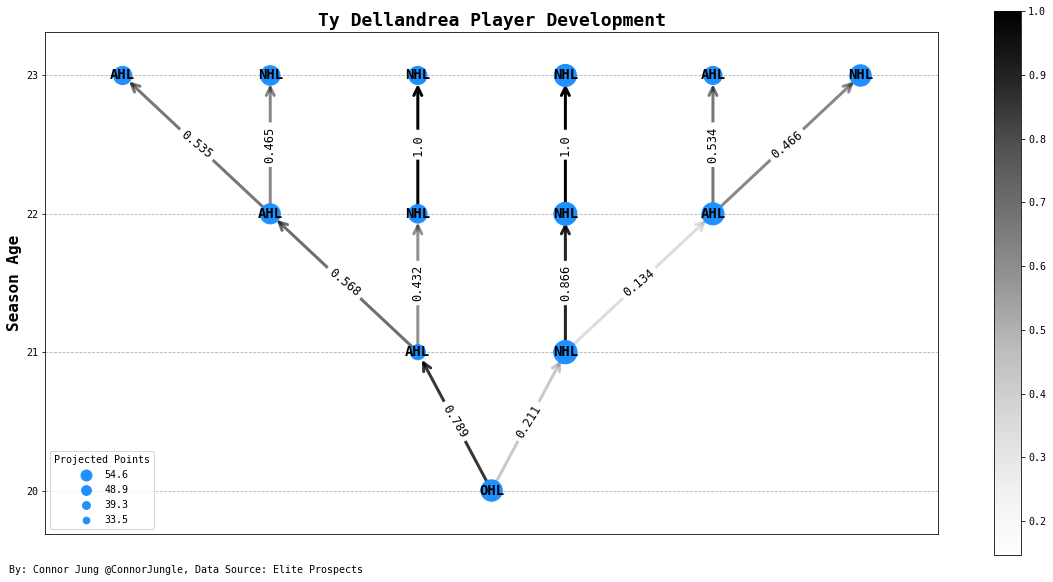

In [35]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib

matplotlib.rc('font',family='monospace')

fig, ax = plt.subplots(figsize=(20,10))

G = nx.convert_matrix.from_pandas_edgelist(df,
                             source='start_node',
                             target='node',
                             edge_attr=['probability', 'epoints'],
                             create_using=nx.DiGraph())

# initialize first node with start league
G.nodes[1]['league'] = player.start_league

# add attributes to nodes
for n in df.node.values:
    G.nodes[n]['league'] = df[df.node == n].league.values.item()
    G.nodes[n]['age'] = df[df.node == n].season_age.values.item()
    G.nodes[n]['epoints'] = df[df.node == n].epoints.values.item()
    G.nodes[n]['cond_prob'] = node_probability(G, n)
    G.nodes[n]['xvalue'] = round(node_expected_value(G, n),3)

# create tree layout and rescale based on age
pos = graphviz_layout(G, prog='dot')
ages = np.arange(df.start_age.astype(int).min(), df.season_age.astype(int).max() + 1, 1)
y = np.array([xy[1] for _,xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

# set params
node_sizes = df.epoints * 10
edge_colors = range(0, 1)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                               pos,
                               node_size=node_sizes,
                               node_color='dodgerblue',
                               ax=ax)
node_labels = nx.get_node_attributes(G, 'league')
nx.draw_networkx_labels(G,
                        pos,
                        node_labels,
                        font_size=14,
                        size=node_sizes,
                        ax=ax, 
                        font_family='monospace', 
                        font_color='black', 
                        font_weight='bold'
                       )

# draw edges
edges = nx.draw_networkx_edges(G,
                               pos, 
                               arrowstyle='->', 
                               arrowsize=20, 
                               edge_cmap=plt.cm.Greys, 
                               width=3,
                               ax=ax)
edge_labels = nx.get_edge_attributes(G, 'probability')
nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels, 
                             font_size=12,
                             ax=ax, 
                             font_family='monospace')

# set alpha value for each edge
for i in range(len(df)):
    edges[i].set_alpha(df.probability.values[i])
    
# colourscale for colourbar
pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Greys)
pc.set_array([(5 + i) / (30 + 4) for i in range(30)])
plt.colorbar(pc)
# axis changes
ax.set_yticks(ages)
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
ax.set_ylabel('Season Age', size=16, weight='bold')
ax.set_aspect(aspect=1.0/ax.get_data_ratio()*0.5625)
custom_leg = [mlines.Line2D([0], [0], marker='o', color='dodgerblue', linestyle='None') for _ in range(0,5)]
# 4 part distirubtion
Q1 = np.percentile(df.epoints.unique(), 25, interpolation = 'midpoint').round(1) 
Q2 = np.percentile(df.epoints.unique(), 50, interpolation = 'midpoint').round(1) 
Q3 = np.percentile(df.epoints.unique(), 75, interpolation = 'midpoint').round(1)
Q4 = np.percentile(df.epoints.unique(), 100, interpolation = 'midpoint').round(1)
point_range=[Q4, Q3, Q2, Q1]
leg = plt.legend(custom_leg, point_range, title = 'Projected Points')
for i, points in enumerate(point_range):
    leg.legendHandles[i]._legmarker.set_markersize(points / 5)

footnote = """By: Connor Jung @ConnorJungle, Data Source: Elite Prospects"""
plt.figtext(0.1, 0.1, footnote)

plt.gca().yaxis.grid(True, linestyle='--',)
fname = '_'.join(player.player_name.split()).lower()
plt.title(f"{player.player_name} Player Development", fontsize=18, fontweight='bold')
plt.savefig(f"{fname}_{player.playerid}_player_development_network_graph.png",
           dpi=300,
           format='png',
            )
plt.show()

In [217]:
pos = graphviz_layout(G, prog='dot')
ages = np.arange(df.start_age.astype(int).min(), df.season_age.astype(int).max() + 1, 1)
y = np.array([xy[1] for _,xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

In [220]:
new_pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

In [51]:
player.projections

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node,epoints,xvalue
0,364033,Akil Thomas,21.0,OHL,AHL,0.727749,76.0,0.677832,0.223096,0.454736,0.085628,0.072180,0.080289,1,2,51.515205,22.537
1,364033,Akil Thomas,21.0,OHL,OHL,0.163351,68.0,1.268347,0.417453,0.850894,0.149320,0.120934,0.138093,1,3,86.247581,22.537
2,364033,Akil Thomas,21.0,OHL,NHL,0.108901,82.0,0.508739,0.167442,0.341297,0.068993,0.059465,0.065395,1,4,41.716568,22.537
0,364033,Akil Thomas,22.0,AHL,AHL,0.729263,76.0,0.756003,0.248824,0.507178,0.095856,0.081130,0.089932,2,5,57.456221,22.537
1,364033,Akil Thomas,22.0,AHL,NHL,0.270737,82.0,0.500690,0.164793,0.335897,0.069212,0.060077,0.065764,2,6,41.056540,22.537
0,364033,Akil Thomas,22.0,OHL,AHL,0.836117,76.0,0.587723,0.193438,0.394285,0.076321,0.064856,0.071832,3,7,44.666936,22.537
1,364033,Akil Thomas,22.0,OHL,NHL,0.163883,82.0,0.481193,0.158376,0.322817,0.066948,0.058191,0.063667,3,8,39.457802,22.537
0,364033,Akil Thomas,22.0,NHL,NHL,1.000000,82.0,0.709041,0.233368,0.475673,0.093398,0.080226,0.088173,4,9,58.141323,22.537
0,364033,Akil Thomas,23.0,AHL,AHL,0.678186,76.0,0.598503,0.196986,0.401517,0.077893,0.066354,0.073382,5,10,45.486228,22.537
1,364033,Akil Thomas,23.0,AHL,NHL,0.321814,82.0,0.476385,0.156793,0.319591,0.066710,0.058182,0.063540,5,11,39.063555,22.537


In [50]:
for node in player.projections.node.values:
    print(node)
    print(player.G[node])

2
{4: {'probability': 0.568, 'epoints': 54.588}, 5: {'probability': 0.432, 'epoints': 40.327}}
3
{6: {'probability': 0.866, 'epoints': 34.379}, 7: {'probability': 0.134, 'epoints': 52.925}}
4
{8: {'probability': 0.535, 'epoints': 48.978}, 9: {'probability': 0.465, 'epoints': 33.578}}
5
{10: {'probability': 1.0, 'epoints': 38.27}}
6
{11: {'probability': 1.0, 'epoints': 33.374}}
7
{12: {'probability': 0.534, 'epoints': 48.818}, 13: {'probability': 0.466, 'epoints': 32.971}}
8
{}
9
{}
10
{}
11
{}
12
{}
13
{}


In [42]:
def node_probability(G, node):
    
    probabilities = []
    for n in sorted(nx.ancestors(G, node))[::-1]:
        probabilities.append(G.edges[(n, node)]['probability'])
        node=n
    return np.prod(probabilities)

def node_expected_value(G, node):

    return sum(G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] for n in nx.ancestors(G, node) | {node})

def nhl_expected_value(G, node):
    
    value = []
    for n in sorted(nx.descendants(G, node)):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['xvalue'] for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

In [36]:
player.G.nodes[1]['league'] = player.start_league
player.G.nodes[1]['age'] = player.start_age
player.G.nodes[1]['epoints'] = player.player_df[player.player_df.season_age == player.player_df.season_age.max()].tp.values.item()
player.G.nodes[1]['cond_prob'] = node_probability(player.G, 1)
player.G.nodes[1]['xvalue'] = round(node_expected_value(player.G, 1),3)

for n in player.projections.node.values:
    player.G.nodes[n]['league'] = player.projections[player.projections.node == n].league.values.item()
    player.G.nodes[n]['age'] = player.projections[player.projections.node == n].season_age.values.item()
    player.G.nodes[n]['epoints'] = player.projections[player.projections.node == n].epoints.values.item()
    player.G.nodes[n]['cond_prob'] = node_probability(player.G, n)
    player.G.nodes[n]['xvalue'] = round(node_expected_value(player.G, n),3)


KeyError: 'league'

In [37]:
player.projections.node

0     2
1     3
0     4
1     5
0     6
1     7
0     8
1     9
0    10
0    11
0    12
1    13
Name: node, dtype: int64

In [43]:
nhl_expected_value(player.G, 2)

KeyError: 'league'

In [137]:
df = df.assign(nhl_xvalue=np.nan,xvalue=np.nan,cond_probability=np.nan,)
for node in df.node:
    df.loc[df.node == node, ['nhl_xvalue']] = node_expected_value(G, node)
    df.loc[df.node == node, ['xvalue']] = nhl_expected_value(G, node)
    df.loc[df.node == node, ['cond_probability']] = node_probability(G, node)

Node 2 xV: 124.17275200000002
Node 3 xV: 15.551628000000001
Node 4 xV: 42.511720020000006
Node 5 xV: 74.86334856000002
Node 6 xV: 32.917013999999995
Node 7 xV: 58.35763208
Node 8 xV: 14.75639497332
Node 9 xV: 48.53716051184
Node 10 xV: 33.473712000000006


In [32]:
df.shape

(12, 21)

### Linear Model for Team Percentage of Scoring

In [422]:
df = pd.read_csv('player_season_stats.csv')
X, y, _ = prepare_features(df, 'ppg_y_plus_1')

In [477]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

def fit_team_scoring_model(data, scoring_metric):
    
    df = get_next_season_data(data)

    df = df[(df.gp < 85)
        & (df.season_age >= 17)
        & (df.season_age <= 23)
        & (df.gp_y_plus_1.notnull())]
    
    age = pd.DataFrame(df.season_age)
    
    df = df.set_index(['playerid', 'player', 'season_age'])
    
    age.index = df.index
    
    features = df[[scoring_metric]].merge(
        pd.get_dummies(df['league'], drop_first=True),
        left_index=True,
        right_index=True).merge(
        pd.get_dummies(age.season_age, drop_first=True),
        left_index=True,
        right_index=True)
    
    label = 'perc_team_tp' if scoring_metric == 'ppg' \
    else 'perc_team_g' if scoring_metric == 'gpg'\
    else 'perc_team_a' 
    
    target = df[label]

    lin_model = LinearRegression()

    lin_model.fit(features[target.notnull().values], target[target.notnull().values])

    print('Mean Absolute Error: ', mean_absolute_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    print('Mean Squared Error: ', mean_squared_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    sns.distplot(target[target.notnull().values])
    plt.show()

    plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
           axisbelow=True, grid=True,
          )
    plt.rc('grid', color='grey', linestyle='dashed')
    plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

    plt.figure(figsize=(10,5),facecolor="#ffffff")

    slope, intercept, r_value, p_value, std_err = stats.linregress(lin_model.predict(features[target.notnull().values]),
                                                                   target[target.notnull().values])

    sns.regplot(x = lin_model.predict(features[target.notnull().values]),
                y = target[target.notnull().values],
                line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                               intercept,
                                                                                               p_value, 
                                                                                               r_value ** 2)})
    plt.title('Predicting Percentage of Team TP [Full LR]')
    plt.legend()
    plt.show()
    
    joblib.dump(lin_model, f'{scoring_metric}_team_model.pkl')
    
    return features

Mean Absolute Error:  0.008165198328830106
Mean Squared Error:  0.0001425965256690886


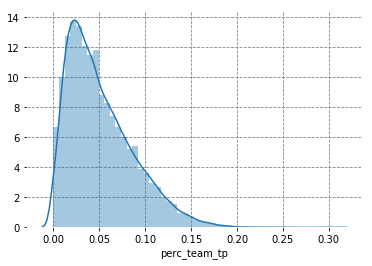

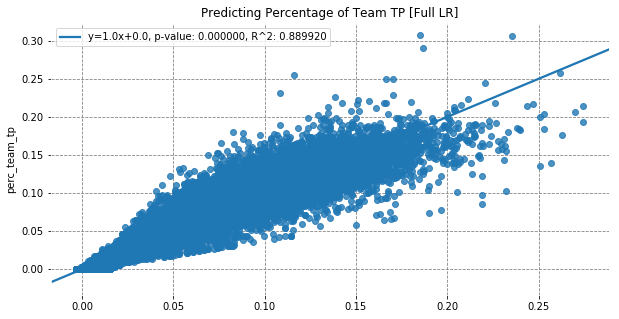

Mean Absolute Error:  0.00850062843903706
Mean Squared Error:  0.0001545322927969362


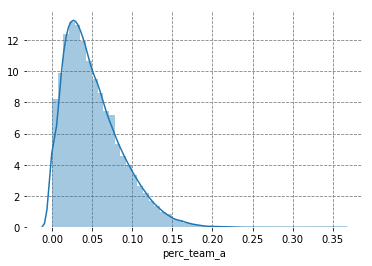

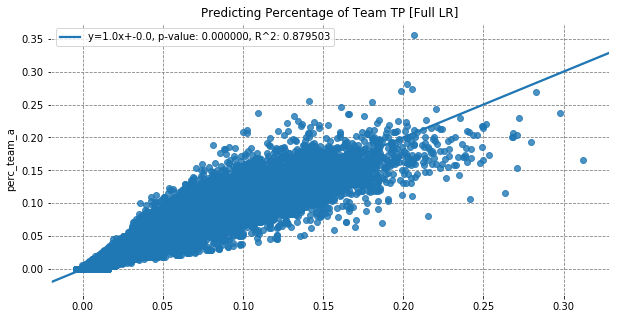

Mean Absolute Error:  0.008348387621897654
Mean Squared Error:  0.00016889321315668453


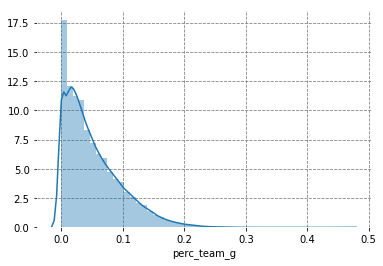

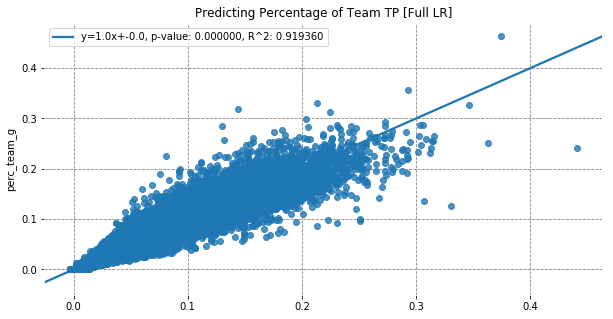

In [478]:
metric = ['ppg', 'apg', 'gpg']
for met in metric:
    feats = fit_team_scoring_model(df, met)

In [223]:
nx.readwrite.json_graph.node_link_data(G)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'league': 'SHL', 'id': 1},
  {'league': 'SHL',
   'age': 21.0,
   'epoints': 23.43,
   'cond_prob': 0.783,
   'xvalue': 36.691,
   'id': 2},
  {'league': 'AHL',
   'age': 21.0,
   'epoints': 42.160000000000004,
   'cond_prob': 0.208,
   'xvalue': 17.539,
   'id': 3},
  {'league': 'NHL',
   'age': 21.0,
   'epoints': 28.208,
   'cond_prob': 0.01,
   'xvalue': 0.564,
   'id': 4},
  {'league': 'SHL',
   'age': 22.0,
   'epoints': 41.14,
   'cond_prob': 0.42595200000000005,
   'xvalue': 52.571,
   'id': 5},
  {'league': 'AHL',
   'age': 22.0,
   'epoints': 56.08,
   'cond_prob': 0.317898,
   'xvalue': 53.483,
   'id': 6},
  {'league': 'NHL',
   'age': 22.0,
   'epoints': 37.72,
   'cond_prob': 0.039150000000000004,
   'xvalue': 4.43,
   'id': 7},
  {'league': 'AHL',
   'age': 22.0,
   'epoints': 68.64,
   'cond_prob': 0.178672,
   'xvalue': 36.792,
   'id': 8},
  {'league': 'NHL',
   'age': 22.0,
   'epoints': 44.362,
   'c

In [ ]:
def simulate_player_development(node_counter=1): 
    
    while player.current_age < 23:
        
        print(f'--- Simulating Seasons --- {player.player_name} --- Age: {int(player.current_age)}')
        
        if node_counter == 1:
            player.generate_league_season(player.player_df)
            player.generate_league_scoring(player.player_df)
            player.interpolate_team_scoring()
            player.league_probs['start_node'] = node_counter
            player.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(player.league_probs))

            player.current_simulation = player.league_probs
            player.projections = player.projections.append(player.current_simulation)
            node_counter += len(player.league_probs)
            player.current_age += 1
            print(f'--- Simulation Complete --- {player.player_name} --- Age: {int(player.current_age)}')
        
        
        print(f'--- Simulating Seasons --- {player.player_name} --- Age: {int(player.current_age)}')
        simulated_seasons = pd.DataFrame()

        for _, sim in player.current_simulation.iterrows():
            player_df = player.fill_player_attributes(sim)
            player.generate_league_season(player_df)
            player.generate_league_scoring(player_df)
            player.interpolate_team_scoring()
            player.league_probs['start_node'] = sim['node']
            player.league_probs['node'] = np.arange(node_counter + 1, node_counter + 1 + len(player.league_probs))
            # Append predictions to projections dataframe
            simulated_seasons = simulated_seasons.append(player.league_probs)
            player.projections = player.projections.append(player.league_probs)
            node_counter += len(player.league_probs)

        player.current_simulation = simulated_seasons
        print(f'--- Simulation Complete --- {player.player_name} --- Age: {int(player.current_age)}')
        player.current_age += 1

        simulate_player_development(node_counter)
        
    player.projections['epoints'] = player.projections.ppg * player.projections.gp